In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def next_day(date):
    """
    This function returns a list containing all the calendar dates, written in the form
    (yyyy,mm,dd), between 2 dates.

    Parameters
    ----------
    date: tuple of int
        A tuple that represents a date written in the form (yyyy,mm,dd).

    Yields
    ------
    date: tuple of int
        A tuple written in the form (yyyy,mm,dd) that rapresent the next calendar day
        of the input date.
    """
    months_30_days = [4,6,9,11]
    months_31_days = [1,3,5,7,8,10,12]
    #check if 28 february on bisextile year
    if date[2] == 28 and date[1] == 2 and date[0]%4 == 0:
        print(date[1])
        date = (date[0],2,29)
    # check if 29 february and if not bisextile year return an error message
    elif date[2] == 29 and date[1] == 2 and date[0]%4 == 0:
        date = (date[0],3,1)
    elif date[2] == 29 and date[1] == 2 and date[0]%4 != 0:
        print("{} is not a valid date".format(date))
        date = 0
    #check if 28 february
    elif date[2] == 28 and date[1] == 2:
        date = (date[0],3,1)
    #check if 31 december
    elif date[2] == 31 and date[1] == 12:
        date = (date[0]+1,1,1)
    #check if end of month
    elif date[2] == 30 and date[1] in months_30_days:
        date = (date[0],date[1]+1,1)
    elif date[2] == 31 and date[1] in months_31_days:
        date = (date[0],date[1]+1,1)
    # in every other case
    elif date[1] < 13 and date[2] < 32:
        date =  (date[0],date[1],date[2]+1)
    # return an error message if there is an invalid date as input
    else:
        print("{} is not a valid date".format(date))
        date = 0
    return date


def create_list_days(start,stop):
    """
    This function returns a list containing all the calendar days, written in the form
    (yyyy,mm,dd), between 2 dates.

    Parameters
    ----------
    start: tuple of int
        Starting date written in the form (yyyy,mm,dd).
    stop: tuple of int
        Last date written in the form (yyyy,mm,dd).

    Yields
    ------
    lst: list of tuples
        A list containg all the days between start and stop (both are included)
    """
    lst = []
    date = start
    while date != stop:
        lst.append(date)
        date = next_day(date)
    lst.append(date)
    return lst

In [3]:
def func(x,C,b,u):
    num = C*np.e**((b-u)*x)
    den = 1+num
    return (1-u/b)*num/den

In [4]:
START = (2021,1,1)
FINISH = (2021,3,1)
days = create_list_days(START,FINISH)
dates = [f"{day[2]}/{day[1]}/{day[0]}" for day in days]

## Reddit, stock prices and memes

On January 2021 the price for Gamestop stoks reached an all time high of 440$. This happened after the members of the reddit  community r/wallstreetbets, started buying a large quantity of the title, causing a chain reaction that led to the high price. <br> 
Once the price rose, the news starded spreading through the social network and new memes and discussions arise from all over the platform. <br> 
I tried to model the spreading of those posts using a simple SIS model. <br>
To retrieve the data I used pushift, a reddit archive, and I found all post created between 01/01/2021 and 03/01/2021 containing the words GME or gamestop in the title. After that I saved those posts of those to an infection database. <br> 
Once a subreddit contains a post about GME I considered it infected. After 15 days from the last post I considered it suscetible. The results are shown in the figure below

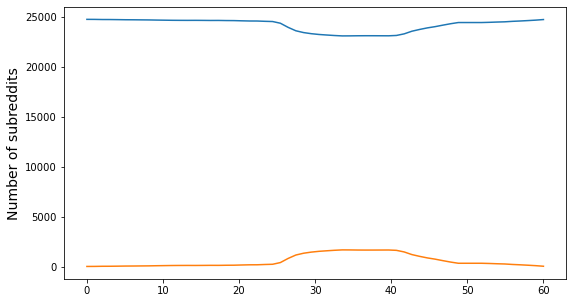

In [5]:
#load data
data = pd.read_csv("../scraping data/data/SIS_GME_final.csv",index_col=0)

#plot the number of suscetible and infected for each day
suscetible = np.zeros(61)
infected = np.zeros(61)
for i,column in enumerate(data):
    suscetible[i] = data[column].to_list().count("suscetible")
    infected[i] = data[column].to_list().count("infected")

infected = infected[1:]
suscetible = suscetible[1:]
xx=np.linspace(0,60,60)
plt.figure(figsize=(9,5))
plt.plot(xx,suscetible,label="Suscetible")
plt.plot(xx,infected,label="Infected")
plt.xlabel("")
plt.ylabel("Number of subreddits",fontsize=14)
#plt.xticks(xx, dates,rotation=60)
plt.show()

As we can the majority of our graph was not infected. This may be due to the fact that there is a very low chanche of infection for subreddits that are not interested in finance or memes (ex. r/ferrari).
Let's see if this change if we consider only subreddits that are in the same cluster as r/wallstreetbets.

In [8]:
from cdlib import algorithms, readwrite
#load clusters
louv_coms = readwrite.read_community_csv("../scraping data/data/louv_coms.csv", ",", str)
clusters=louv_coms.communities 


#save cluster containing r/wallstreetbets
for cluster in clusters:
    if "wallstreetbets" in cluster:
        wsb_cluster = cluster
        
        print(len(cluster))

813


In [9]:
new_df = data.iloc[[0],:]
#create a new infected database containing only the subreddit in the cluster of wallstreetbets
for subreddit in wsb_cluster:
    if data[data["subreddit"] == subreddit].index.to_list() != []:
        i = data[data["subreddit"] == subreddit].index.to_list()[0]
        new_df=pd.concat([new_df,data.iloc[[i],:]])
        
new_df.drop(0,inplace=True)



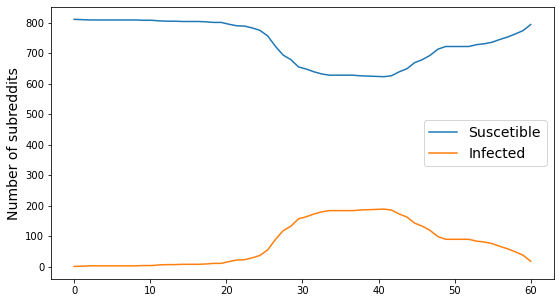

In [10]:
#plot the number of suscetible and infected for each day
suscetible_cluster = np.zeros(61)
infected_cluster = np.zeros(61)
for i,column in enumerate(data):
    suscetible_cluster[i] = new_df[column].to_list().count("suscetible")
    infected_cluster[i] = new_df[column].to_list().count("infected")

infected_cluster = infected_cluster[1:]
suscetible_cluster = suscetible_cluster[1:]
xx=np.linspace(0,60,60)
plt.figure(figsize=(9,5))
plt.plot(xx,suscetible_cluster,label="Suscetible")
plt.plot(xx,infected_cluster,label="Infected")
plt.xlabel("")
plt.ylabel("Number of subreddits",fontsize=14)
#plt.xticks(xx, dates,rotation=60)
plt.legend(fontsize=14)
plt.show()

The percentage of infected subreddits did not improve by much

## Relationship between infected and stock price

Let's see the relationship between the logarithm of the stock price and the number of infected subreddits.

In [9]:
err_inf = infected*.05
new_inf = infected + infected*.05
for i,value in enumerate(new_inf):
    if value < 250:
        err_inf[i]=infected[i]*.2
        new_inf[i]=infected[i] + infected[i]*.2

In [10]:
american_dates = [f"{day[1]}/{day[2]}/{day[0]}" for day in days]
gme=pd.read_csv("../scraping data/data/gme_stock.csv")
gme=gme.iloc[::-1]
gme_stock= np.zeros(60)
for i,date in enumerate(american_dates):
    for j in gme.index.to_list():
        if date in gme["Date"].iat[j]:
            gme_stock[i] = gme["High"].iat[j]
gme_stock
gme_stock[0] = 19.1
for i , value in enumerate(gme_stock):
    if i != 0:
        if value == 0:
            gme_stock[i] = gme_stock[i-1]
        


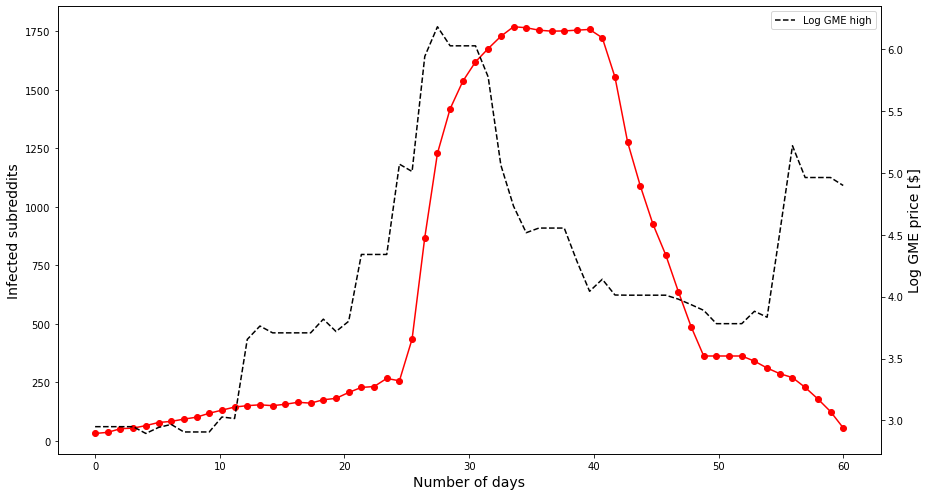

In [11]:
fig, ax1 = plt.subplots(figsize=(13,7))
ax1.errorbar(x=xx,y=new_inf,color="red",marker="o")
ax1.set_xlabel('Number of days',fontsize=14)
ax1.set_ylabel('Infected subreddits', fontsize=14)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Log GME price [$]',fontsize=14)  # we already handled the x-label with ax1
ax2.plot(xx,np.log(gme_stock),"--",label="Log GME high",color="black")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.savefig("images/price_and_infected.png")

plt.show()

inserire discorso sul fatto che l'interesse non è legato al prezzo

## Spreading analysis

I used an SIS model to fit the data. In particular I used the function $$i(t)=(1-\frac{\mu}{\beta})\frac{Ce^{(\beta-\mu)t}}{1+Ce^{(\beta-\mu)t}} $$ <br>
As error on the number of data I used the following criteria:
1. 5% of the total infected for days with more than 250 infected.
2. 20% for days with less than 250 infected. <br>
The idea is that it is easier to miss an infected subreddit while the infection is in it early stage.

## Constant R$_{0}$

The first thing i considered is fitting the data considering the parameters $\beta,\mu$ constant with time

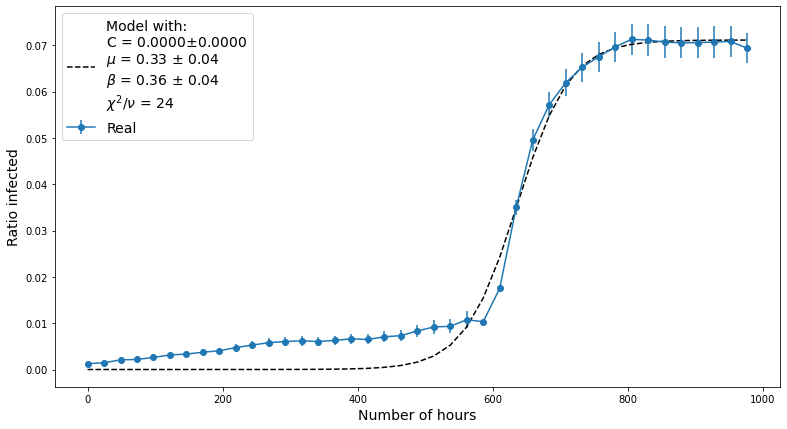

Adjusted X2=24.37
C=0.0000+-0.0000
b=0.359+-0.043
u=0.333+-0.041
R_0=1.08+- 0.18


In [12]:
y = new_inf[0:41]/data.shape[0]
d_y = err_inf[0:41]/data.shape[0]
x = xx[0:41]*24

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.3,0.5,0.4))
c_1 = popt[0]
b_1 = popt[1]
u_1 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu 
label = f"Model with:\nC = {popt[0]:.4f}$\pm${err_0:.4f}\n$\mu$ = {popt[2]:.2f} $\pm$ {err_2:.2f}\n$\\beta$ = {popt[1]:.2f} $\pm$ {err_1:.2f}\n$\chi^2$/$\\nu$ = {adj_chi:.0f}"
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label=label)
plt.xlabel('Number of hours',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("images/constant_R_0.png")
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.4f}+-{err_0:.4f}")
print(f"b={popt[1]:.3f}+-{err_1:.3f}")
print(f"u={popt[2]:.3f}+-{err_2:.3f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

As we can see from the value of $\frac{\chi^2}{\nu}$ the model does not fit the data well.

## From R$_0$ to R$_T$

During the epidemics something may have happened that chanced the spreading parameters, mainly the drastic price increase of the GME stock. <br>
For this reason i divided the time domain in 3 different regions: <br>
1. A linear phase from 01/01 to 25/01
2. An exponential increas from 25/01 to 09/02
3. An exponential decrease from 10/02 onwards <br> <br>
For each of those phases I computed $\beta_t,\mu_t,R_t$. Let's see if the results improve

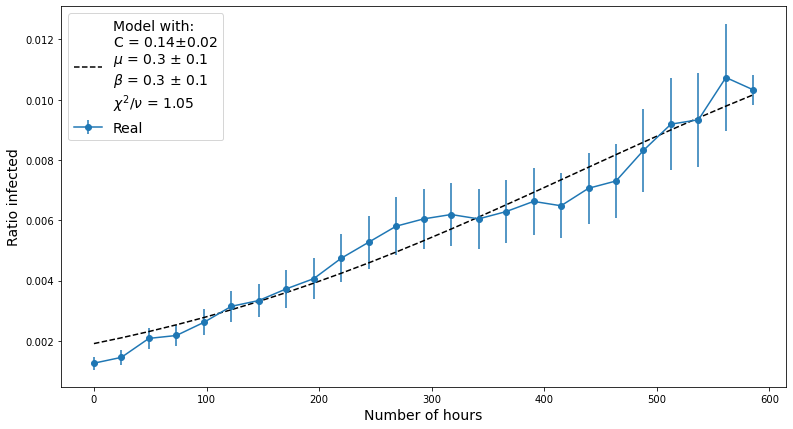

Adjusted X2=1.05
C=0.1437+-0.0243
b=0.298+-0.106
u=0.293+-0.105
R_0=1.02+- 0.51


In [14]:
y = new_inf[0:25]/data.shape[0]
d_y = err_inf[0:25]/data.shape[0]
x = xx[0:25]*24

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.3,0.5,0.4))
c_1 = popt[0]
b_1 = popt[1]
u_1 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
label = f"Model with:\nC = {popt[0]:.2f}$\pm${err_0:.2f}\n$\mu$ = {popt[2]:.1f} $\pm$ {err_2:.1f}\n$\\beta$ = {popt[1]:.1f} $\pm$ {err_1:.1f}\n$\chi^2$/$\\nu$ = {adj_chi:.2f}"
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label=label)
plt.xlabel('Number of hours',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("images/linear_part.png")
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.4f}+-{err_0:.4f}")
print(f"b={popt[1]:.3f}+-{err_1:.3f}")
print(f"u={popt[2]:.3f}+-{err_2:.3f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

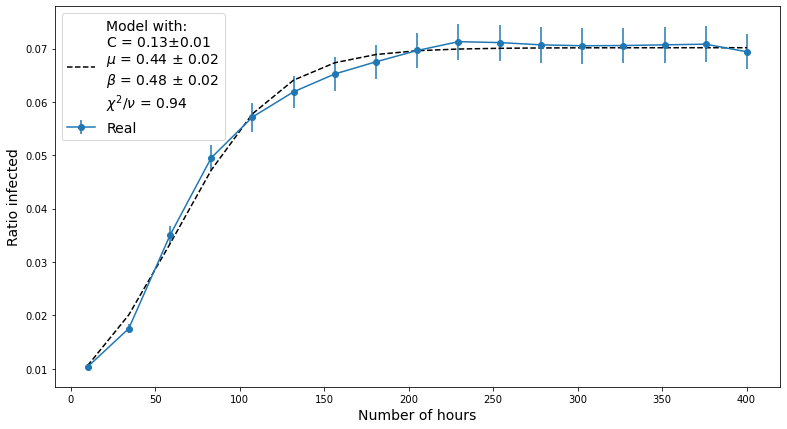

Adjusted X2=0.94
C=0.13+-0.01
b=0.478+-0.025
u=0.444+-0.023
R_0=1.08+- 0.08


In [15]:
y = new_inf[24:41]/data.shape[0]
d_y = err_inf[24:41]/data.shape[0]
x = (xx[24:41]-24)*24

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.5,.3,.1),bounds=((0,0,0,),(1,1,1)))
c_2 = popt[0]
b_2 = popt[1]
u_2 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
label = f"Model with:\nC = {popt[0]:.2f}$\pm${err_0:.2f}\n$\mu$ = {popt[2]:.2f} $\pm$ {err_2:.2f}\n$\\beta$ = {popt[1]:.2f} $\pm$ {err_1:.2f}\n$\chi^2$/$\\nu$ = {adj_chi:.2f}"
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label=label)
plt.xlabel('Number of hours',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("images/exponential_part.png")
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.2f}+-{err_0:.2f}")
print(f"b={popt[1]:.3f}+-{err_1:.3f}")
print(f"u={popt[2]:.3f}+-{err_2:.3f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

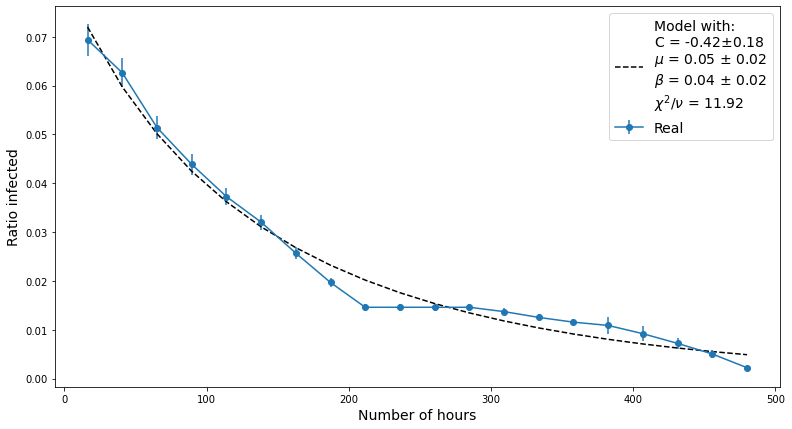

Adjusted X2=11.92
C=-0.42+-0.18
b=0.043+-0.023
u=0.048+-0.022
R_0=0.90+- 0.63


In [16]:
y = new_inf[40:]/data.shape[0]
d_y = err_inf[40:]/data.shape[0]
x = (xx[40:]-40)*24

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution

popt, pcov = curve_fit(func, x, y,p0=(-.42,0.5,0.5),bounds=((-10,0,0),(1,1,1)))

c_3 = popt[0]
b_3 = popt[1]
u_3 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
label = f"Model with:\nC = {popt[0]:.2f}$\pm${err_0:.2f}\n$\mu$ = {popt[2]:.2f} $\pm$ {err_2:.2f}\n$\\beta$ = {popt[1]:.2f} $\pm$ {err_1:.2f}\n$\chi^2$/$\\nu$ = {adj_chi:.2f}"
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label=label)
plt.xlabel('Number of hours',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("images/exponential_decrease.png")
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.2f}+-{err_0:.2f}")
print(f"b={popt[1]:.3f}+-{err_1:.3f}")
print(f"u={popt[2]:.3f}+-{err_2:.3f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

The first two model fit the data quite well, infact we have a value of $\frac{\chi^2}{\nu}\approx 1$, while the last model does not yield good results. <br>
Now let's put it all togheter

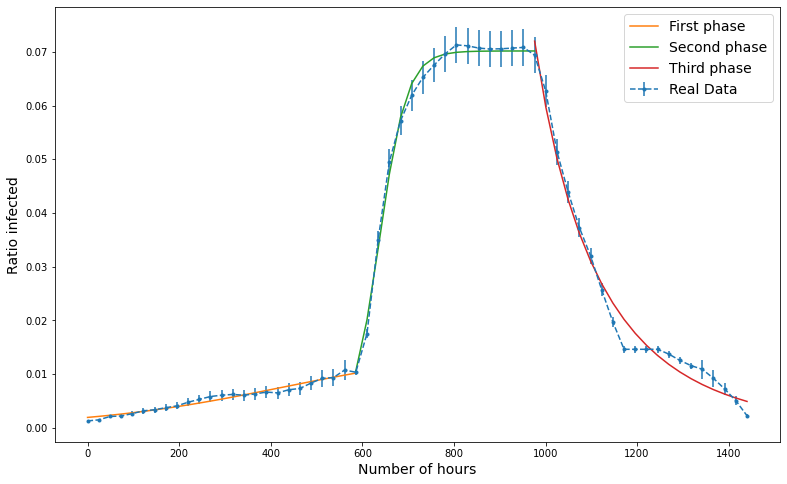

In [17]:
y = new_inf/data.shape[0]
d_y = err_inf/data.shape[0]
x = xx*24

plt.figure(figsize=(13,8))
#compute best parameter to approximate real distribution

plt.errorbar(x,y,yerr=d_y,marker=".",label="Real Data",linestyle="--")
plt.plot(x[0:25], func(x[0:25], c_1,b_1,u_1),label="First phase")
plt.plot(x[24:41], func(x[24:41]-24*24, c_2,b_2,u_2),label="Second phase")
plt.plot(x[40:], func(x[40:]-40*24, c_3,b_3,u_3),label="Third phase")

plt.xlabel('Number of hours',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("images/all_toghether.png")
plt.show()

As we can see from the value of $\frac{\chi^2}{\nu}$ the results are much better this way, expetially for the first two phases

## Spreading and connected components

One of the main assumpion on epidemic spreading on social networks is that a patogen (in our case a meme) can be spreaded only to its neighbors. I wanted to test this assumption and to do so I looked at the number of weakly connected components in the infected subgraph. Considering that once a subreddit is infected it stays infected the number of weakly connected components should remain the same or decrease in time.

In [19]:
data_si = data.copy()
for column in data_si:
    if column != "subreddit":
        lst_ind = data_si[data_si[column] == "infected"].index.to_list()
        for index in lst_ind:
            data_si.loc[index,column:] = "infected"


In [20]:
lst_infected = []
for column in data:
    if column != "subreddit":
        daily_infec = data_si[data_si[column] == "infected"]["subreddit"].to_list()
        daily_infec = list(pd.unique(daily_infec))
        daily_infec.remove("infected")
        lst_infected.append(daily_infec)

In [21]:
import networkx as nx

df = pd.read_csv("../scraping data/data/data_subreddit_cleaned.csv",index_col=0)
g= nx.convert_matrix.from_pandas_edgelist(df,source = "parent",target="to",
                                                        edge_attr=True,create_using=nx.DiGraph())

In [22]:
lst_weakly_com = []
for daily_lst in lst_infected:
    lst_weakly_com.append(nx.number_weakly_connected_components(g.subgraph(daily_lst)))


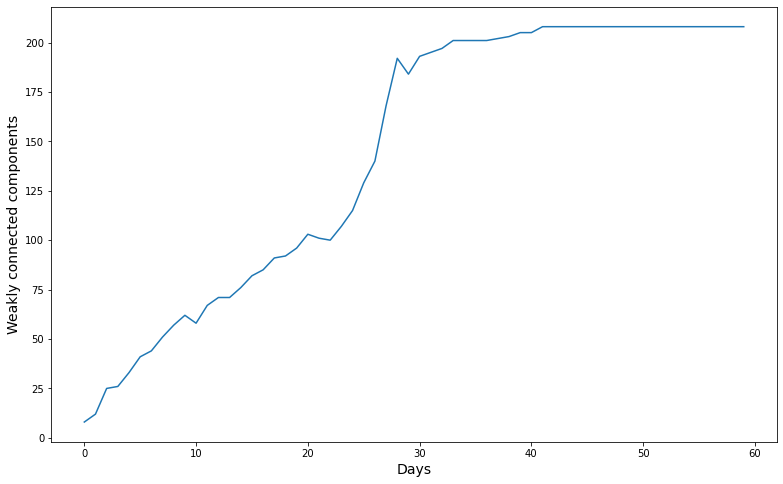

In [23]:
plt.figure(figsize=(13,8))
plt.plot(lst_weakly_com)
plt.xlabel("Days",fontsize=14)
plt.ylabel("Weakly connected components",fontsize=14)
plt.savefig("images/weakly_connected.png")
plt.show()

Surprisingly the opposite is true. This mean that new infectons do not stem from the infected node neighbors, but pop up randomly. This can be due 3 different reasons:
1. Our network is only a static snapshot of a time-varying and more complicated network.
2. The number of subreddits that are infected is much higher than what we found.
3. Our network is not complete, we are missing some key subreddits
4. The presence of the r/all subreddit "breaks" the network structure.

Differently for the majority of social networks, In which a user can see only see posts of friends or pages he follows, in reddit there is a special page called r/all, that contains all the most popular posts of the day. This means each reddit user can see news and memes about game stop, thus meaning each subreddit can be infected even if it has no infected neighbors.